**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 4** - Kalman filter

**Duration: 3 hours**

**Introduction:**

In this lab, you are provided with the set of coordinates (x,y – horizontal and vertical) describing the trajectories of pedestrians moving acrooss a scene. Your task is to simulate the observed positions of the pedestrians by adding observation noise, then to track the subjects using a Kalman filter. In other words, you need to estimate the next (x,y) positions, from the observations of the previous positions.


*Simulating the observed coordinates*

Choose one of the trajectories in the dataset. This data will be considered the real trajectory. Generate the observed directory by adding observation noise $\delta_t \sim \mathcal{N}(0,\sigma^{2}_{R})$ to the (x,y) coordinates.


*Designing the Kalman filter*

Your task is to **design a Kalman filter** based on a constant velocity model, which tracks the next (x,y) position of the object, from the observation of the previous positions. The code must be based on the following model.

*   The state vector contains coordinates and velocities: $z^{T}_{t} = (z_{1t}, z_{2t}, v_{1t}, v_{2t})$ (see slides). The object has initial coordinates (0,0) and velocity $(\Delta,Δ)$.
*   Only the coordinates (but not the velocities) are observed. This leads to a linear dynamical system with:

$A = \left( \begin{matrix} 1 & 0 & \Delta & 0 \\ 0 & 1 & 0 & \Delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$


$C = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{matrix} \right)$

and B = D = 0.

*   $\Sigma_{Q}$, and $\Sigma_{R}$ should be set to:

$\Sigma_{Q} = \sigma^{2}_{Q}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

$\Sigma_{R} = \sigma^{2}_{R}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

To see if your Kalman filter is working well, you should plot the estimated position of the object over time with respect to the true position (i.e., the first two entries of the state vector) and the observed position. Depending on the chosen parameters, for each coordinate the graph may look something like this:

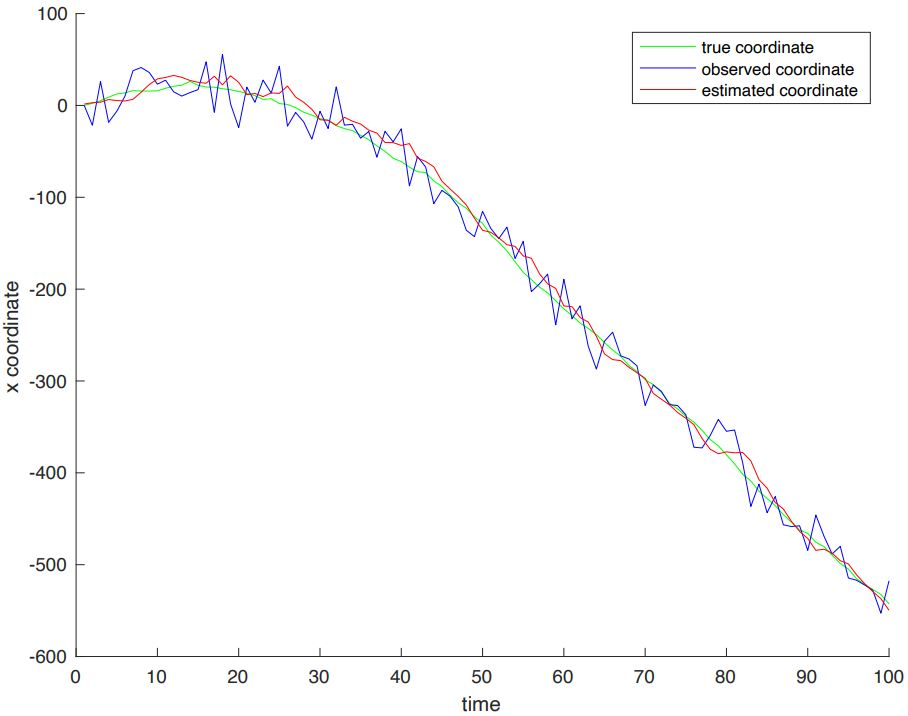

**Suggestion**: when implementing your Kalman filter, you will have to choose initial values for **$\mu_{t}$** and **$\Sigma_{t}$**. Provided that you do not make very unreasonable assumptions, the Kalman filter will update those estimates from observed data, so the initial choices are not very critical. 

Test your Kalman filter modifying the values of some of the parameters, including standard deviations **$\sigma_{Q}$** and **$\sigma_{R}$**, initial values for **$\mu_{t}$** and **$\Sigma_{t}$** and the value of **$\Delta$**.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# %pip install pandas ndjson

import ndjson
import pandas as pd
import numpy as np

#Dataset origin: https://paperswithcode.com/dataset/trajnet-1
#The crowds_students001 file is loaded, and formatted as a list of numpy vectors

with open('./crowds_students001_trackonly.ndjson') as f:
  data = ndjson.load(f)

# data is a list of dictionaries as follows: {"track": {"f": int, "p": int, "x": float, "y": float}}
# f is the frame number, p is the person number, x and y are the coordinates of the person
# display(data)

p='-1'  # initialize the id of the person to a value that is not in the data

person_dict = []

for ii in range(len(data)): # iterate over all the data
  # the data in the dictionary are ordered by person, so we can use this to create a list of lists
  if(p!=data[ii]['track']['p']):  # read the id of the person from the dictionary, if it is new create a new list for the positions of that person
    p=data[ii]['track']['p']  # save the id of the person
    person_dict.append([])  # initialize a new list for the positions of the person
  person_dict[p].append((data[ii]['track']['x'],data[ii]['track']['y']))  # add to the list of the person the position of the person
  # at the end we will have a list of lists, where each list is the trajectory of a person

# convert the list of lists to a list of numpy arrays
person_dict_numpy = []
for ii in range(148):  # select the first 148 people. The dataset globally conaints 414 people, but we are selecting the first 148
  person_dict_numpy.append(np.array(person_dict[ii], dtype=float))

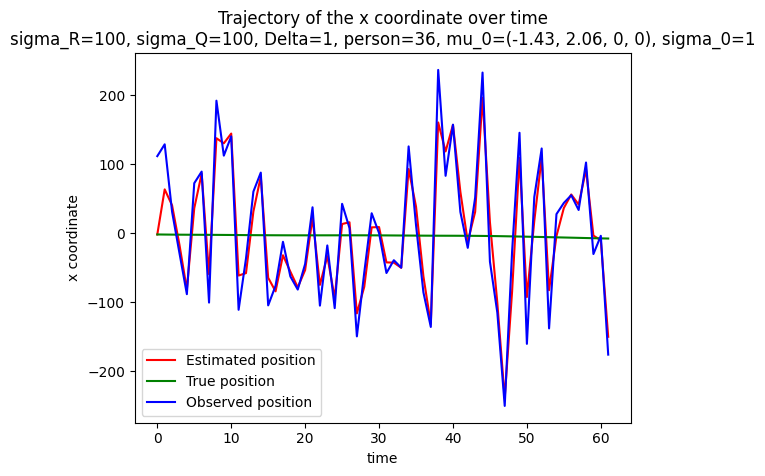

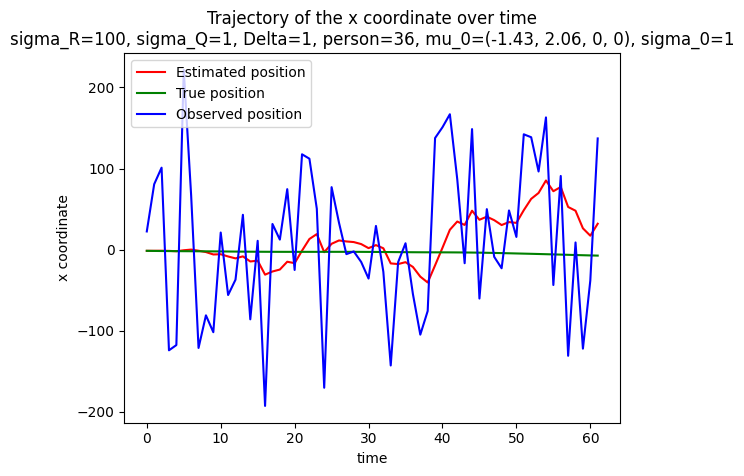

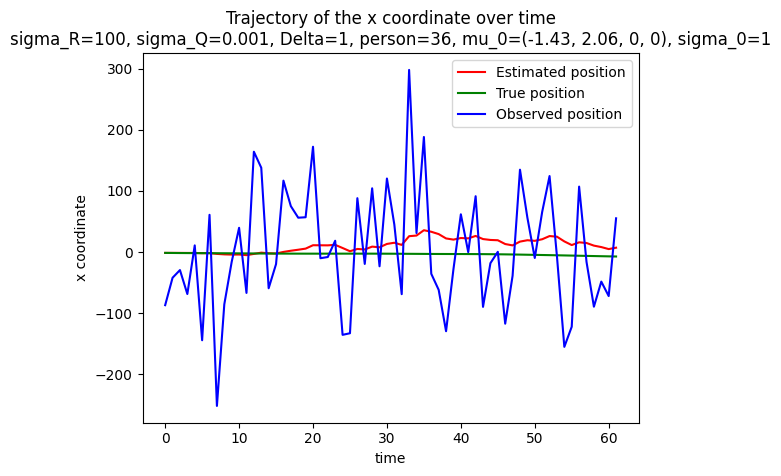

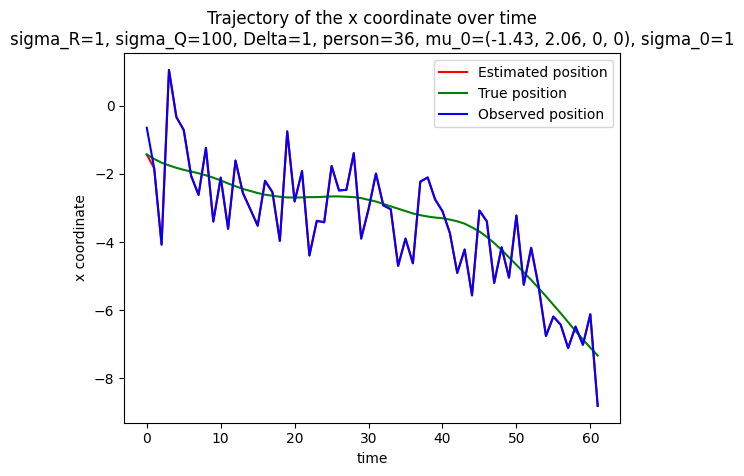

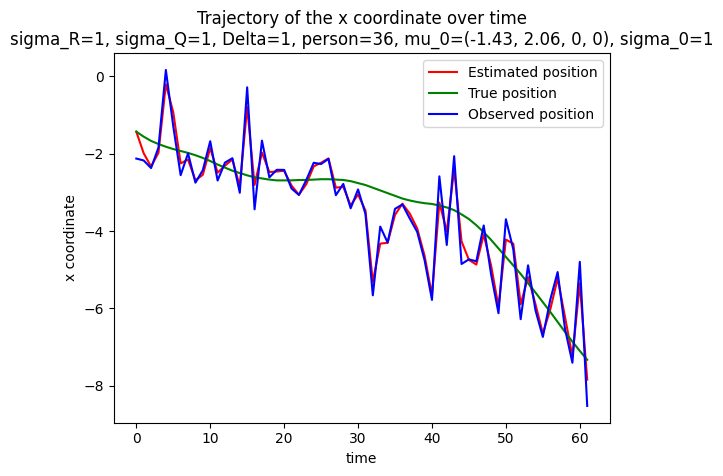

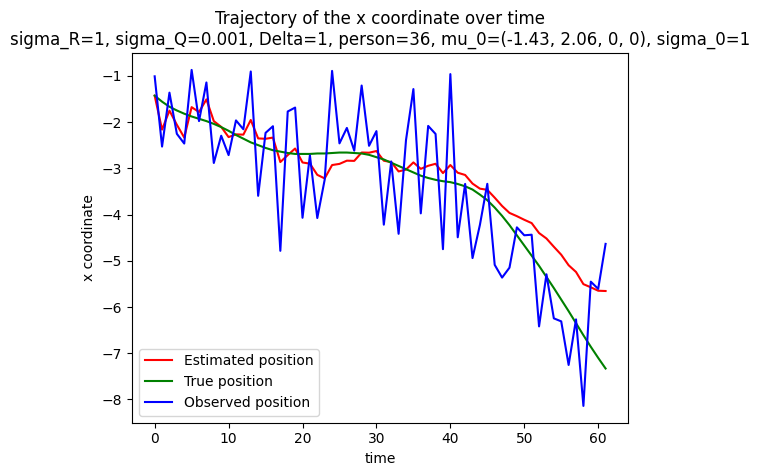

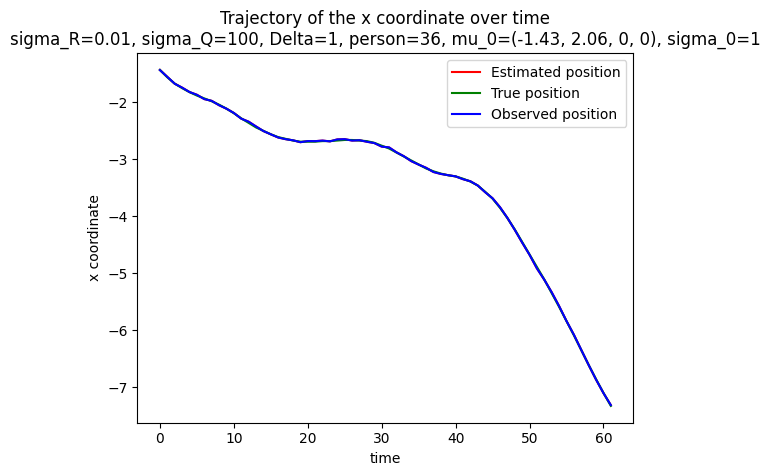

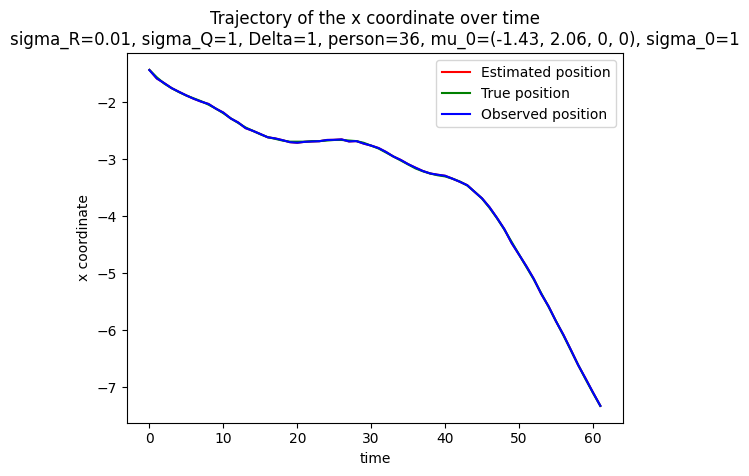

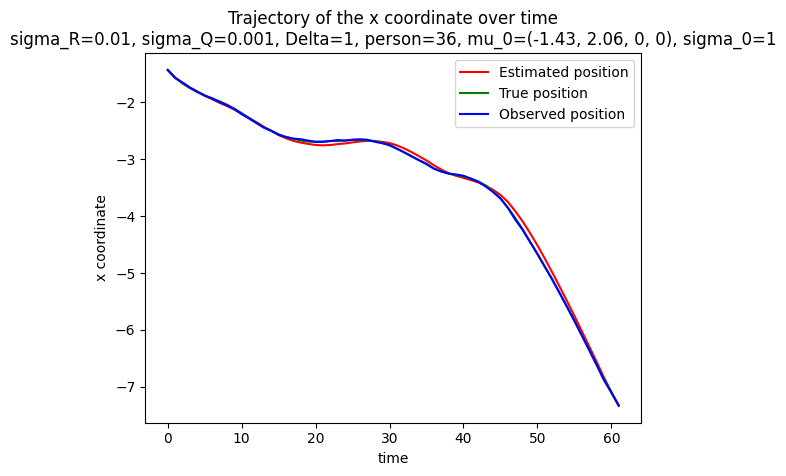

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Implement the kalman filter as a function using the numpy library, the matrix products can be done using the np.dot function
# The matrix inversion can be done using the np.linalg.inv    

def kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R):
  # Predict the state at the next time step
  mu_est = np.dot(A, mu_tmin1)  # mu_t|t-1 = A_t*mu_t-1
  # this prediction doesn't consider possible errors that can occures, so we want to update it by taking in consideration also the measured value y(t)
  # Note that also the measured value could be affected by errors and we must consider this
  sigma_est = np.dot(np.dot(A, sigma_tmin1), A.T) + Q # sigma_t|t-1 = A_t * cov_t-1 * (A_t)^T + Q

  # Calculate the Kalman gain - we use this coefficent to balance the relevance of the measurement value and the predicted, cause we want to update our prediction by considering both
  # K goes from 0 to 1, and it tend to 1 if R tend to 0. This because R = 0 means that our measurements have maximal reliability, so we want to give more relevance to the measurements then the
  # predictions. If Q tend to 0 means that our predictions are reliable, so K tend to 0 cause we want to give more weight to our predictions and remove it from the observations.
  K = np.dot(np.dot(sigma_est, C.T), np.linalg.inv(np.dot(np.dot(C, sigma_est), C.T) + R))  # K_t = cov_t|t-1 * (C_t)^T * (C_t * cov_t|t-1 * (C_t)^T + R)^(-1)
  # Now we have to update our prediction by using the K coefficent evaluated. The formula is: z(t) = z(t) + K(y(t) - C * z(t)). To our initial prediction we are summing the error made by our 
  # prediction weighted by the K value. The error made by the prediction is evaluated by using the predicted state z(t) to estimate which is the observed value, then we will apply the difference
  # between the actual observation and the predicted one.
  # Update the estimate of the state
  y_hat = np.dot(C, mu_est) # y_hat_t = C_t * mu_t|t-1
  r = y - y_hat # r_t = y_t - y_hat_t
  mu_est = mu_est + np.dot(K, r)  # mu_t = mu_t|t-1 + K_t * r_t
  # Update the estimate of the covariance
  sigma_est = np.dot(np.eye(4) - np.dot(K, C), sigma_est) # cov_t = (I - K_t * C_t) * cov_t|t-1

  return mu_est, sigma_est

# we decide which person to track by selecting a random index between 0 and 147
rand_index = random.randint(0,147) # choose a random index between 0 and 147
true_positions = person_dict_numpy[rand_index] # extract the trajectory of the selected person  

#Define parameter delta
Delta = 1 # constant velocity

# our state vector is: z(t) = (s_1(t), s_2(t), v_1(t), v_2(t))^T -> we must multiply the state vector by the matrix A to get the state at the next time step
# this matrix rappresents the state transition model
A = np.array([[1, 0, Delta, 0],
             [0, 1, 0, Delta],
             [0, 0, 1, 0 ],
             [0, 0, 0, 1 ]])


# Define the measurement matrix - we measure the position, but not the velocity
C = np.array([[1, 0, 0, 0],  # x is measured directly
             [0, 1, 0, 0]]) # y is measured directly

# Set the standard deviation of the measurement noise

sigma_R = [100, 1, 0.01]  # standard deviation of the measurement noise - how much noise there is in the measurements
# high value of R means that the measurements are very noisy, so the observed position will be far from the true position and will have a high variance
# low value of R means that the measurements are very accurate, so the observed position will be close to the true position and will have a low variance

sigma_Q = [100, 1, 0.001]  # standard deviation of the system noise - how much trust we have in the estimatetions
# high value of Q means that we trust the measurements more than the model, so the estimated position will be closer to the observed position
# low value of Q means that we trust the model more than the measurements, so the estimated position will be far from the observed position

for sigma_r in sigma_R: # i see the behavior of the model with different values of sigma_R, that corresponds to the variance of the measurement error
  for sigma_q in sigma_Q: # i see the behavior of the model with different values of sigma_Q, that corresponds to the variance of the prediction error
    # Define the prediction noise covariance matrix
    Q = (sigma_q**2)*np.eye(4)  # Q = sigma_Q^2 * I, we are building a diagonal matrix with the variance of the prediction error

    # Define the measurement noise covariance matrix
    R = (sigma_r**2)*np.eye(2)  # R = sigma_R^2 * I, we are building a diagonal matrix with the variance of the measurement error

    # Set the initial state and covariance
    mu_0 = (true_positions[0,0], true_positions[0,1], 0, 0)  # (x, y, v_x, v_y) initial state of the person with space coordinates and velocity vector
    sigma_0 = 1  # uncertainty in the initial position

    mu = np.zeros([len(true_positions), 4]) # build the matrix to store the estimated states, each row is a vector of a specific time stamp
    sigma = np.zeros([len(true_positions), 4, 4]) # build the matrix to store the estimated covariance matrices, each row is a covariance matrix of a specific time stamp
    mu[0] = mu_0  # set the initial state
    sigma[0] = sigma_0*np.eye(4)  # set the initial covariance matrix
    y = np.zeros([len(true_positions), 2])  # build the matrix to store the observed positions, each row is a vector of a specific time stamp
    y[0] = true_positions[0] + np.random.normal(0,sigma_r,2)  # set the initial observed position by reading the actual position and adding a measurement noise
    for t in range(1,len(true_positions)):  # iterate over all the time steps
      # Get the observed coordinates at time t 
      # Note: the observed position is simulated by adding gaussian noise to the true_positions
      y[t] = true_positions[t] + np.random.normal(0,sigma_r,2)  # y_t = x_t + noise - measure the position of the person at time t by adding noise to the true position
      # apply the kalman filter on the observed coordinates 
      mu_est, sigma_est = kalman_filter(y[t], mu_tmin1 = mu[t-1], sigma_tmin1 = sigma[t-1], A = A, C = C, Q = Q, R = R)
      mu[t] = mu_est  # store the estimated state
      sigma[t] = sigma_est  # store the estimated covariance

    #Use the matplotlib library to plot the true positions, observed positions y and the results of the kalman filtering
    #You should obtain a plot which resembles the one in the figure 
    #Plot the trajectory of the x coordinate over time and the trajectory of the y coordinate over time into two separate plot
    plt.figure()
    plt.plot(mu[:,0], label='Estimated position', color='red')
    plt.plot(true_positions[:,0], label='True position', color='green')
    plt.plot(y[:,0], label='Observed position', color='blue')
    plt.xlabel('time')
    plt.ylabel('x coordinate')
    plt.legend()
    plt.title(f'Trajectory of the x coordinate over time\nsigma_R={sigma_r}, sigma_Q={sigma_q}, Delta={Delta}, person={rand_index}, mu_0={mu_0}, sigma_0={sigma_0}')
    plt.show()

    # plt.figure(figsize=(10,5), dpi=100)
    # plt.plot(mu[:,1], label='Estimated position', color='red')
    # plt.plot(true_positions[:,1], label='True position', color='green')
    # plt.plot(y[:,1], label='Observed position', color='blue')
    # plt.xlabel('time')
    # plt.ylabel('y coordinate')
    # plt.legend()
    # plt.title(f'Trajectory of the y coordinate over time\nsigma_R={sigma_r}, sigma_Q={sigma_q}, Delta={Delta}, person={rand_index}, mu_0={mu_0}, sigma_0={sigma_0}') 
    # plt.show()